# Environment setup

## Download code and data


In [15]:
!pip install imagecodecs tifffile

In [16]:
# Clone the GitHub repository and cd into it
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

Cloning into 'ml-segmentation-project'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 118 (delta 63), reused 65 (delta 27), pack-reused 0
Receiving objects: 100% (118/118), 709.66 KiB | 9.34 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/ml-segmentation-project/ml-segmentation-project


In [17]:
# Download the data using the fetch script
!./fetch-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.8M  100 72.8M    0     0  9732k      0  0:00:07  0:00:07 --:--:-- 16.8M


## Useful imports and settings

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import unet
from dataset import CellSegmentationDataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [19]:
BATCH_SIZE = 2
TRAIN_PERCENT = 0.8

img_transforms = transforms.Compose([
      # Convert to 0-1 float
      transforms.Lambda(lambda img: (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img))),  
      transforms.ToTensor(),
      transforms.CenterCrop(1024),
])
target_transforms = transforms.Compose([
      transforms.Lambda(lambda img: img.astype(np.float32)),
      transforms.ToTensor(),
      # Limit to 0-1 for foreground-background segmentation
      transforms.Lambda(lambda img: img.clamp(max=1.0)),
      transforms.CenterCrop(1024),
])

full_dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  pattern="Neuroblastoma",
                                  transform=img_transforms,
                                  target_transform=target_transforms,
                                )

train_size = int(len(full_dataset) * TRAIN_PERCENT)
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Training

In [26]:
model = unet.UNet().to(device)

In [21]:
summary(model, input_size=(1, 1024, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             640
              ReLU-2       [-1, 64, 1024, 1024]               0
            Conv2d-3       [-1, 64, 1024, 1024]          36,928
              ReLU-4       [-1, 64, 1024, 1024]               0
         MaxPool2d-5         [-1, 64, 512, 512]               0
            Conv2d-6        [-1, 128, 512, 512]          73,856
              ReLU-7        [-1, 128, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]         147,584
              ReLU-9        [-1, 128, 512, 512]               0
        MaxPool2d-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 256, 256, 256]         295,168
             ReLU-12        [-1, 256, 256, 256]               0
           Conv2d-13        [-1, 256, 256, 256]         590,080
             ReLU-14        [-1, 256, 2

We first define the evaluation functions we'll be using during training.

In [22]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean().item()

In [23]:
def evaluate(model, loader):
    n_val = len(loader)
    tot = 0
    for image, labels in loader:
        with torch.no_grad():
            pred = model(image.to(device))
            tot += dice_loss(pred, labels.to(device))
    return tot / n_val

In [24]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Training phase
        model.train()

        epoch_loss = 0
        epoch_dice_loss = 0
        epoch_samples = len(train_loader)
            
        torch.cuda.empty_cache()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)              
            # zero the parameter gradients
            optimizer.zero_grad()   
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            epoch_loss += loss.item()
            epoch_dice_loss += dice_loss(outputs, labels)

        #scheduler.step()
        
        print("Epoch train loss: {}".format(epoch_loss / epoch_samples))
        print("Epoch dice loss: {}".format(epoch_dice_loss / epoch_samples))

        # Evaluation phase
        model.eval()
        val_loss = evaluate(model, val_loader)
        if val_loss < best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())

        print("Epoch validation loss: {}".format(val_loss))

        time_elapsed = time.time() - since
        print('Took {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model

In [27]:
TRN_EPOCHS = 20
WEIGHT_DECAY = 0
LEARNING_RATE = 0.001
MOMENTUM = 0.99

torch.cuda.empty_cache()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.BCELoss()
# Maybe interesting to use later
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

model = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=TRN_EPOCHS)

Epoch 1/20
----------
Epoch train loss: 0.6595615914889744
Epoch dice loss: 0.7295791379043034
Epoch validation loss: 0.6379325687885284
Took 0m 14s

Epoch 2/20
----------
Epoch train loss: 0.5282102397509983
Epoch dice loss: 0.6416579357215336
Epoch validation loss: 0.3841959089040756
Took 0m 14s

Epoch 3/20
----------
Epoch train loss: 0.21700321457215718
Epoch dice loss: 0.3140150947230203
Epoch validation loss: 0.16966819763183594
Took 0m 15s

Epoch 4/20
----------
Epoch train loss: 0.44636284559965134
Epoch dice loss: 0.21252662794930594
Epoch validation loss: 0.16426391899585724
Took 0m 14s

Epoch 5/20
----------
Epoch train loss: 0.14987668448260852
Epoch dice loss: 0.17105539781706675
Epoch validation loss: 0.2459457367658615
Took 0m 14s

Epoch 6/20
----------
Epoch train loss: 0.136453672179154
Epoch dice loss: 0.18572248305593217
Epoch validation loss: 0.29184433817863464
Took 0m 14s

Epoch 7/20
----------
Epoch train loss: 0.1305066187466894
Epoch dice loss: 0.16896674462727

# Generating predictions

We now generate predictions for one batch of data and compare it to the ground truth.

In [28]:
inputs, labels = next(iter(val_loader))
with torch.no_grad():
    outputs = model.predict(inputs.to(device))

<Figure size 432x288 with 0 Axes>

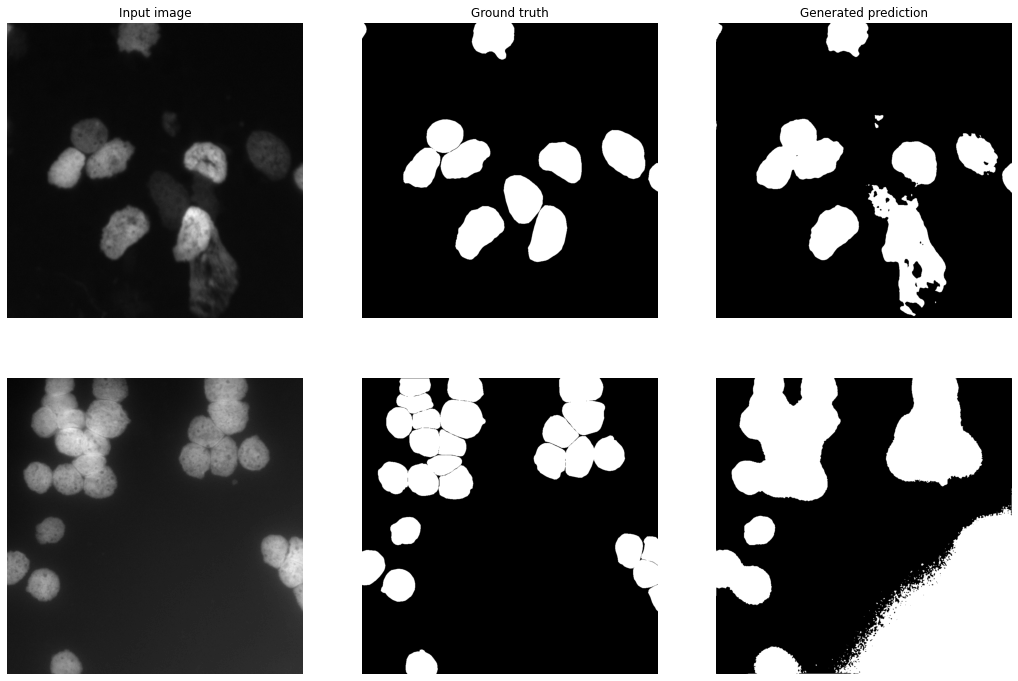

In [29]:
plt.gray()
count = len(inputs)
fig = plt.figure(figsize=(6 * 3, 6 * count))
axs = fig.subplots(count, 3)

for ax in axs.flat:
    ax.axis("off")

column_labels = ["Input image", "Ground truth", "Generated prediction"]
for ax, label in zip(axs[0], column_labels):
    ax.set_title(label)

for i in range(count):
    axs[i, 0].imshow(inputs[i].cpu().squeeze())
    axs[i, 1].imshow(labels[i].cpu().squeeze())
    axs[i, 2].imshow(outputs[i].cpu().squeeze())

fig.show()